#### Import Libraries

In [398]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pandas_profiling import ProfileReport

from summarytools import dfSummary

import plotly.io as pio

In [399]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [400]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'SWE'

# Dependant variable
dep_var = 'TIV'  

### Load data

In [401]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date").asfreq('MS')

In [402]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847
2006-02-01,303,0.608882,7.3,3.42,67.391665
2006-03-01,634,1.122431,7.6,3.55,92.858327
2006-04-01,1097,1.484866,8.0,3.84,95.325089
2006-05-01,926,1.573034,7.4,3.89,107.940718
...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900
2022-09-01,666,10.837620,7.1,2.08,76.413249
2022-10-01,711,10.853250,7.7,2.20,76.986837


In [403]:
df.describe()

,Orders,CPI,UR,LTIR,TIV
count,204.000000,204.000000,204.000000,204.000000,204.000000
mean,804.750000,1.677467,7.621569,1.781569,89.423103
std,292.446469,2.086685,0.898288,1.411966,21.542311
min,110.000000,-1.871640,5.800000,-0.290000,41.016545
25%,634.000000,0.303343,6.900000,0.577500,75.448427
50%,804.500000,1.482136,7.700000,1.590000,88.339246
75%,992.000000,2.123759,8.200000,3.185000,101.288087
max,1739.000000,11.464530,9.500000,4.450000,223.974669


### Plot data

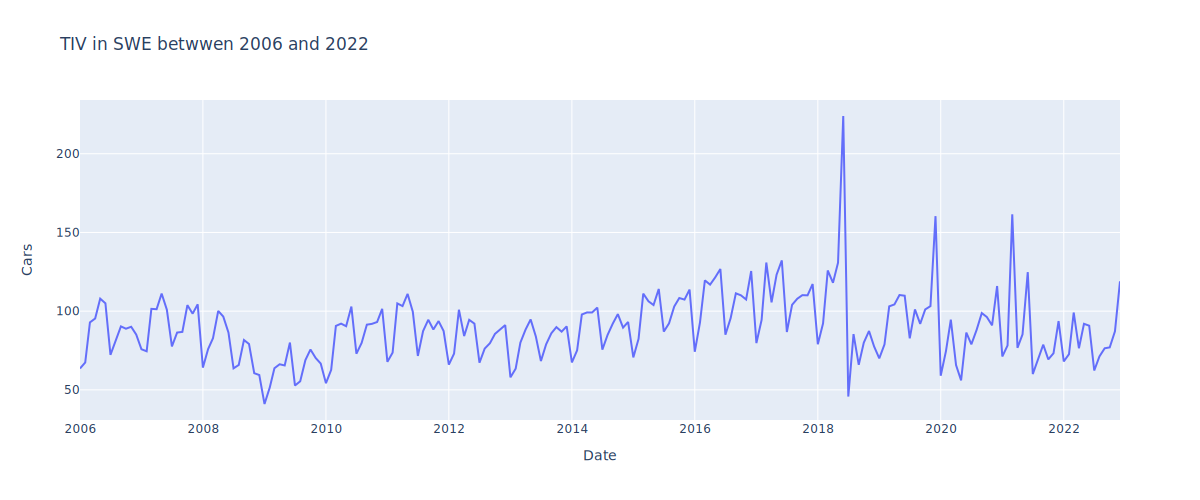

In [404]:
title = dep_var + ' in ' + country + ' betwwen 2006 and 2022'

fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.index, y=df[dep_var], mode='lines')))

fig.update_layout(height=500, width=1200, title=go.layout.Title(text=title),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))

fig.update_xaxes(rangeslider_visible=False)
fig.show()

C:\Users\ne74255\AppData\Local\Temp/ipykernel_3968/431621056.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



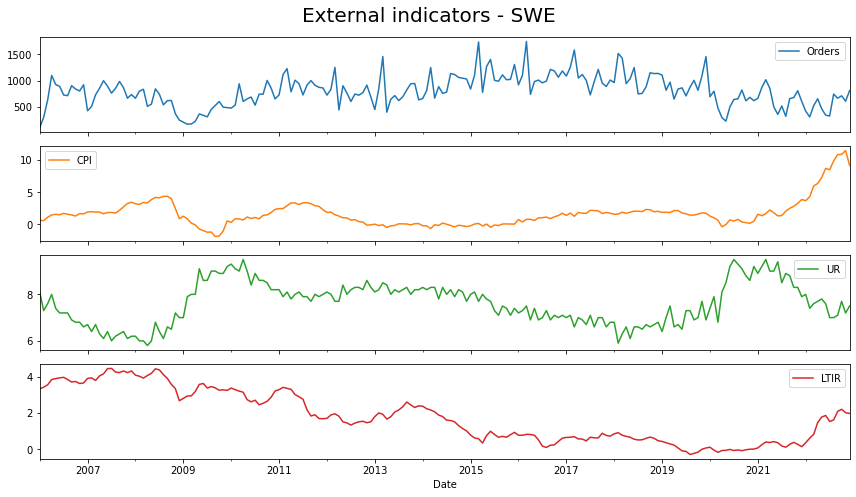

In [405]:
# Plot time series
fig, ax = plt.subplots(figsize=(12, 7))
df.loc[:, df.columns != dep_var].plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    ax       = ax, 
)
fig.suptitle('External indicators - ' + country, fontsize=20)
fig.tight_layout();

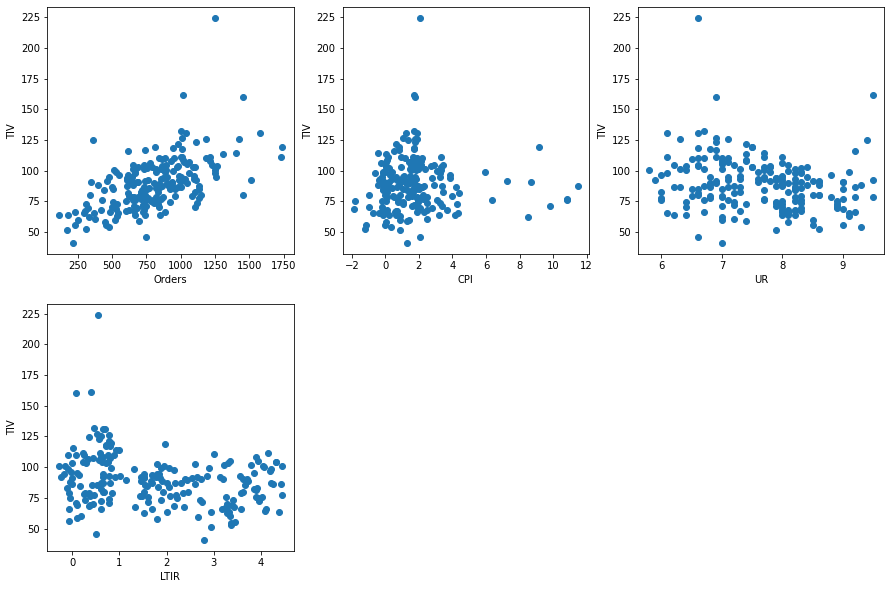

In [406]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    
    ind_var = df.loc[:, df.columns != dep_var]  # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(15, 10))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        plt.subplot(num_rows, num_cols, fig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(df,3)

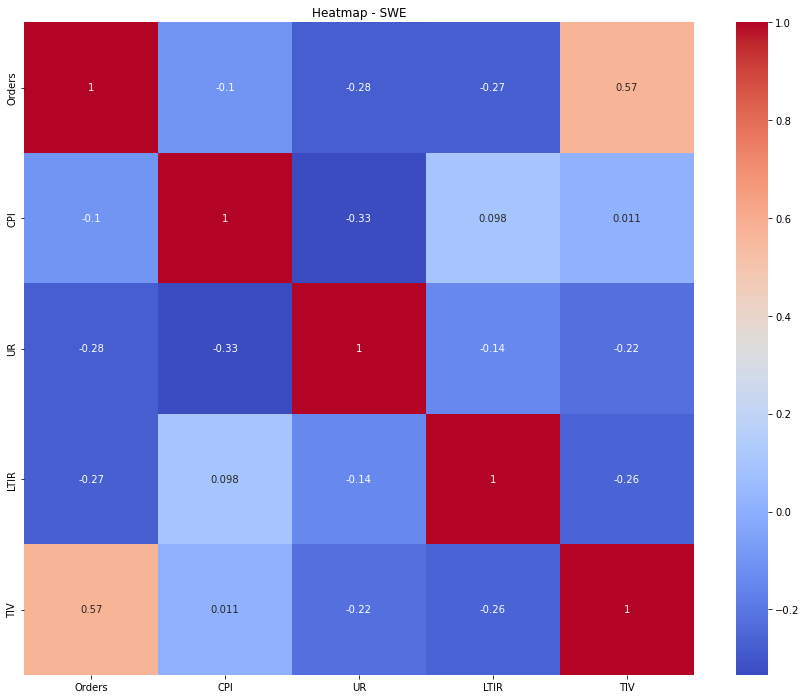

In [407]:
# Plot the correlations as a heatmap
plt.figure(figsize=(15, 12))
ax = plt.axes()
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2g', ax=ax)
ax.set_title('Heatmap - ' + country)
plt.show()

### Seasonality

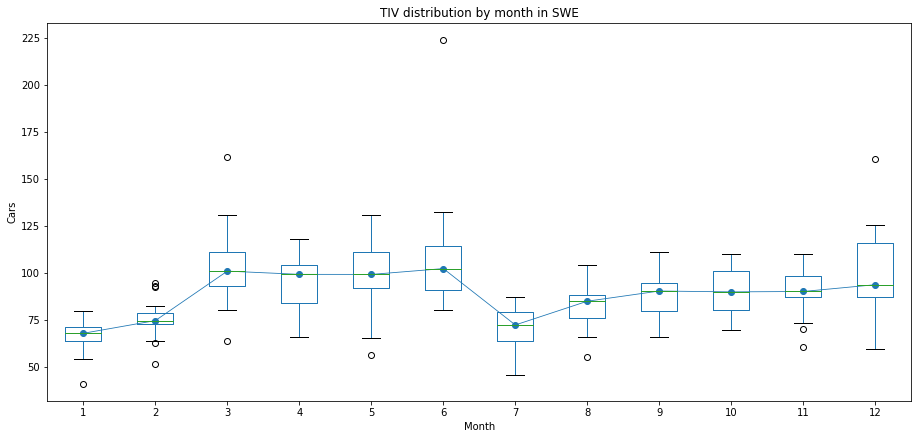

In [408]:
# Boxplot for annual seasonality
fig, ax = plt.subplots(figsize=(15, 7))
df['Month'] = df.index.month
df.boxplot(column=dep_var, by='Month', ax=ax,)
df.groupby('Month')[dep_var].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Cars')
ax.set_title(dep_var + ' distribution by month in ' + country)
fig.suptitle('');

### Trend

Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

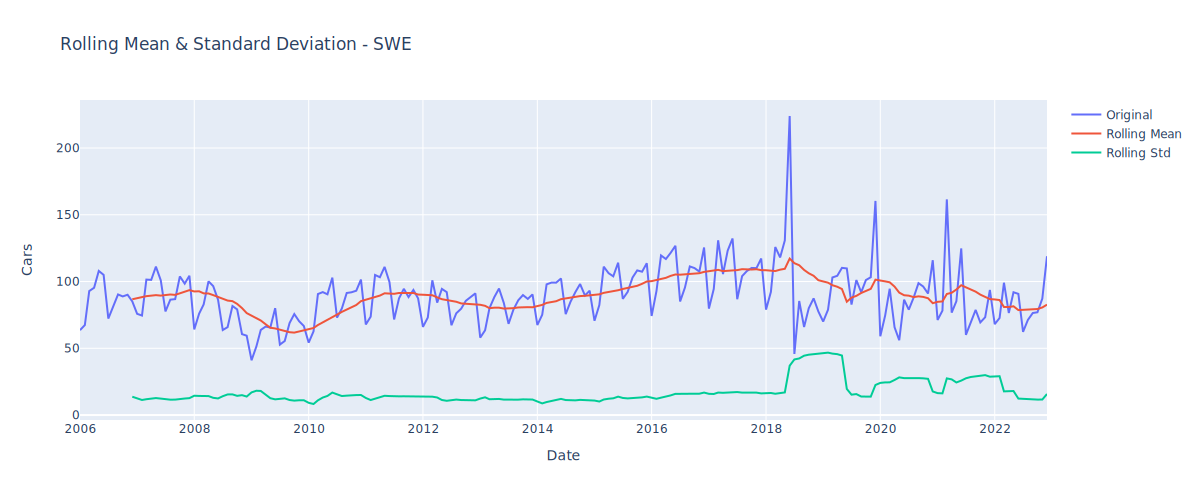

In [409]:
# Determine rolling statistics
# Wwindow size 12 denotes 12 months, giving rolling mean at yearly level
window_size = 12
df["rolling_avg"] = df[dep_var].rolling(window=window_size).mean() 
df["rolling_std"] = df[dep_var].rolling(window=window_size).std()

title = 'Rolling Mean & Standard Deviation - ' + country

fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=df.index, y=df[dep_var], mode='lines', name= 'Original')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df['rolling_avg'], mode='lines', name= 'Rolling Mean')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df['rolling_std'], mode='lines', name= 'Rolling Std')))

fig.update_layout(height=500, width=1200, title=go.layout.Title(text=title),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))

fig.show()

df.drop(['rolling_avg', 'rolling_std'], axis=1, inplace=True)

### Time series decomposition 

We separate a time series into its components: trend, seasonality, and residuals. The trend represents the slow-moving changes in a time series. It is responsible for making the series gradually increase or decrease over time. The seasonality component represents the seasonal pattern in the series. The cycles occur repeatedly over a fixed period of time. The residuals represent the behavior that cannot be explained by the trend and seasonality components. They correspond to random errors, also termed white noise.

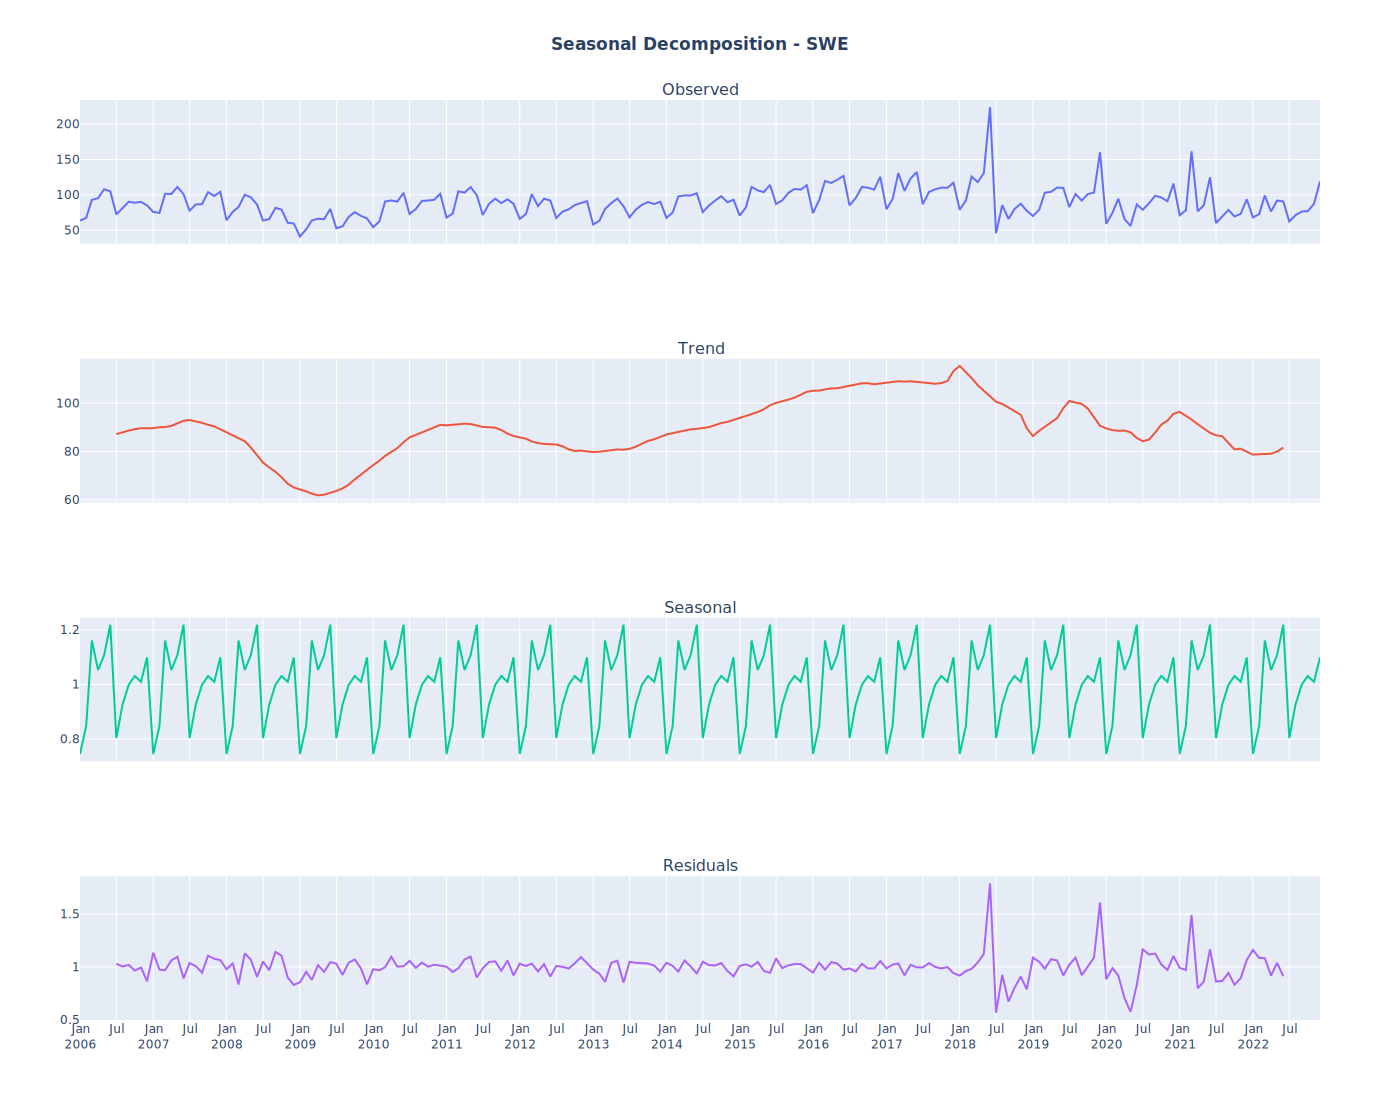

In [410]:
def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition - " + country):
    x_values = dates
    return (
        make_subplots(
            rows=4,
            cols=1,
            shared_xaxes=True,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'), row=1, col=1,)
        .add_trace(go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'), row=2, col=1,)
        .add_trace(go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'), row=3, col=1,)
        .add_trace(go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'), row=4, col=1,)
        .update_layout(height=1100, width=1400, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False)
        .update_xaxes(dtick="M6",tickformat="%b\n%Y")        
    )

decomposition = seasonal_decompose(df[dep_var], model='multiplicative', period=12)
fig = plot_seasonal_decompose(decomposition, dates=df.index)
fig.show()    

### Stationarity (Augmented Dickey–Fuller Test)

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

* Null Hypothesis: The data is not stationary.

* Alternative Hypothesis: The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

* p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

Results of Dickey-Fuller Test:
Test Statistic                  -2.214623
p-value                          0.200981
#Lags Used                      13.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


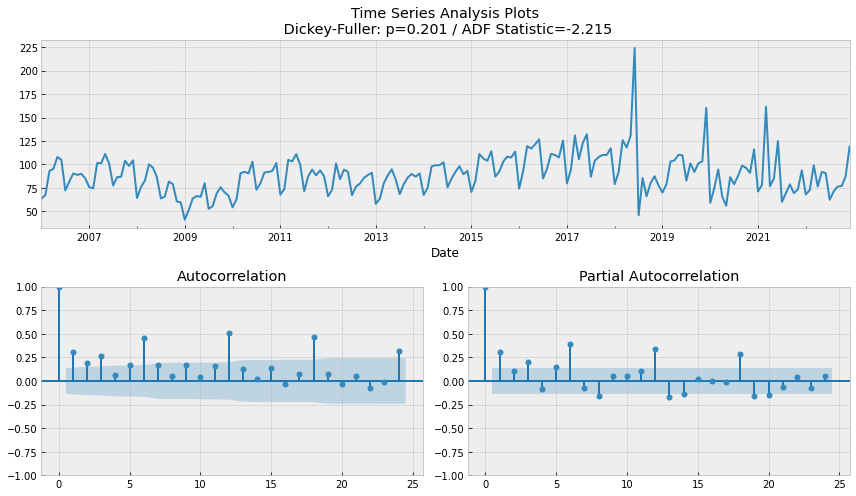

In [411]:
# Time series analysis plot
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        result = adfuller(y, autolag='AIC',regression='c')
        adf = result[0]
        p_value = result[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.3f} / ADF Statistic={1:.3f}'.format(p_value, adf))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        
# Data Stationarity check using Augmented Dickey Fuller(ADF) test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return dfoutput['p-value']

tsplot(df[dep_var])
p_value = adf_test(df[dep_var])     

Results of Dickey-Fuller Test:
Test Statistic                  -4.931553
p-value                          0.000030
#Lags Used                      12.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


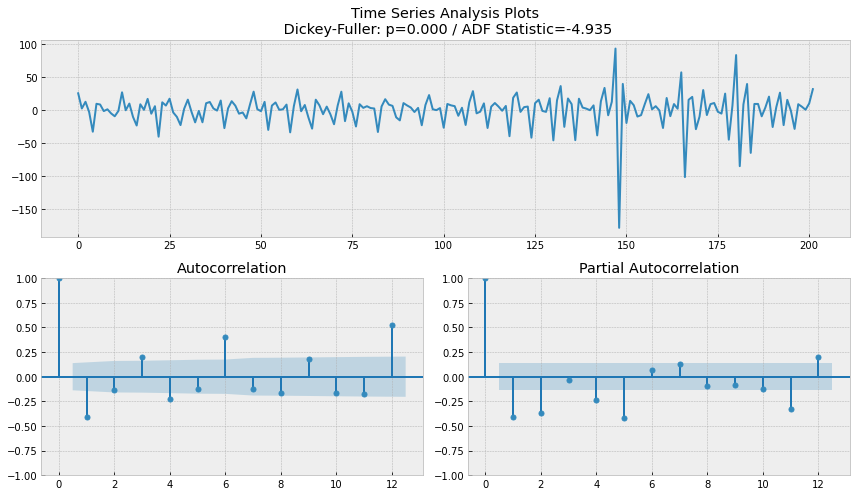

In [412]:
if p_value > 0.05:
    # Take the first difference to make our series stationary    
    data_diff = np.diff(df[dep_var],1)
    tsplot(data_diff[1:], lags=12)
    p_value = adf_test(data_diff)  

### Correlation plots

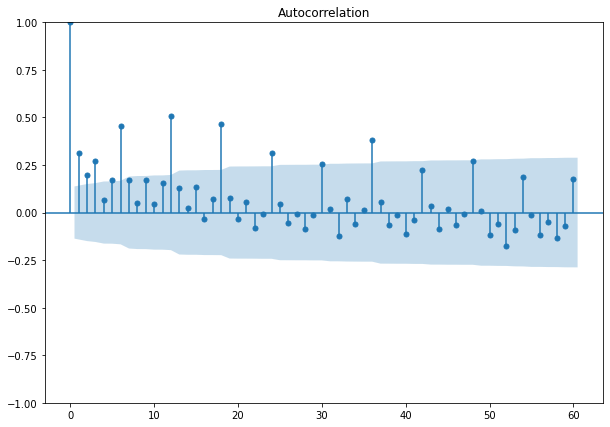

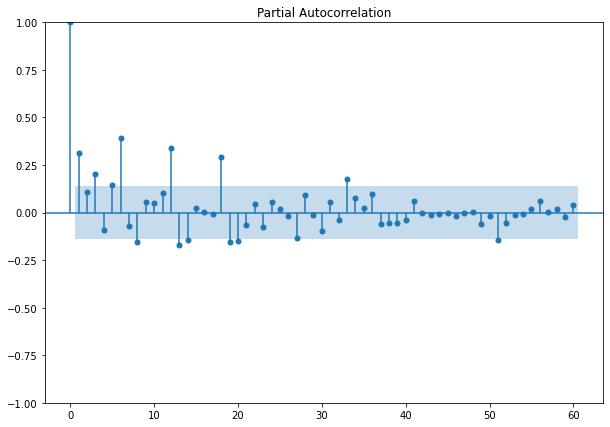

In [413]:
# Autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 7))
plot_acf(df[dep_var], ax=ax, lags=60)

# Partial autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 7))
plot_pacf(df[dep_var], ax=ax, lags=60, method='ywm')
plt.show()

In [414]:
df.drop('Month', axis=1, inplace=True)

In [415]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847
2006-02-01,303,0.608882,7.3,3.42,67.391665
2006-03-01,634,1.122431,7.6,3.55,92.858327
2006-04-01,1097,1.484866,8.0,3.84,95.325089
2006-05-01,926,1.573034,7.4,3.89,107.940718
...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900
2022-09-01,666,10.837620,7.1,2.08,76.413249
2022-10-01,711,10.853250,7.7,2.20,76.986837


In [416]:
target = df[[dep_var]]

In [417]:
target

,TIV
Date,
2006-01-01,63.568847
2006-02-01,67.391665
2006-03-01,92.858327
2006-04-01,95.325089
2006-05-01,107.940718
...,...
2022-08-01,71.260900
2022-09-01,76.413249
2022-10-01,76.986837


### Save file with target features

In [418]:
# Save data to Excel  
with pd.ExcelWriter("Datasets/Output_files/target.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    target.to_excel(writer, sheet_name=country) 

### Pandas profiling

In [419]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [420]:
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


### Summary Tools

In [421]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Orders[int64],Mean (sd) : 804.8 (292.4)min < med < max:110.0 < 804.5 < 1739.0IQR (CV) : 358.0 (2.8),185 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABXUlEQVR4nO3cMU7DMBiG4R+ElMWs6cCCfAG4ACdg4gRee6ZsOQGn4B4sDGT2EilSOjCn2G2SJv7eZ/Zg9ZUcx1Z6N46joXz3t54A1vFw6wmcU9f1h3PukDI2xvjbdd3n0nPaq02Hds4dQgg/KWPbtn1aej57xtItgtAiCC2C0CIILWLTu+4cfd+/eu+PKWMVX8WKCV1V1SOvYtNYukUQWgShRRBaBKFFEFoEoUUQWkQxByY5FE/RJEMrnqKxdIsgtAhCiyC0CEKLILQIQosgtAhCiyC0CMkj0BylnIsT+h+lnIuvHjrnU9hhGF7MLOlHxnmrh878FPZt6fmoYDMmgtAiZlm6ee5u3yyhee5uH0u3CEKLILQIQosgtIjJXTevTGWZDM0rU1m4vZpRzpWmmVmM8dk595049qorUELPKOdK0+xvJQwhfKWMbZrm3Xt/8R/gEnonrr0XZ9ct4gQrDnw5iisrzQAAAABJRU5ErkJggg=="">",0(0.0%)
2,CPI[float64],Mean (sd) : 1.7 (2.1)min < med < max:-1.9 < 1.5 < 11.5IQR (CV) : 1.8 (0.8),204 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABOElEQVR4nO3cMWrDMBhAYbcU7EFdnaFL8QXSC/QQPYHWXMsn6NbzdOlQz14MBnfM0hiJKG7S9775BxseyCAh3y3LUun/u//rF9A2HrZ+YNu2byGEXcrsOI7fwzC8X/qdCDYPHULYxRi/Umb7vn+69PtQuHRDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQRfa6cw4q5nneV1WVtNetcoqEzjyoeC3xTOVx6YYwNIShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBpi80t2OaZpeum67pAy683LdVcduq7rR29eluHSDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQ5zc6761G5IegKw7GfrWbkh6ALLOpRviqo8pdXTuX5GRoTO/588hhM/Ss7nzTdPsY4wfKbO/fZp+ABkSXJES2tToAAAAAElFTkSuQmCC"">",0(0.0%)
3,UR[float64],Mean (sd) : 7.6 (0.9)min < med < max:5.8 < 7.7 < 9.5IQR (CV) : 1.3 (8.5),37 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABUElEQVR4nO3aMU6EQBSA4dGY0GDLFnZcQC/gITzBtl6LE3gqC6lpSEjwBBuZLAzP+f+vppjk333wCA/ruibV7/HsA6iMp7MPcIau6z7atr1suXaapp9xHL+OPtPRkKHbtr1cr9fvLdcOw/By9HlKcHRDGBoCObpzzPP81vf955ZrI9/PDf2Hpmmea7ifO7ohiv+jiatNBMVDE1ebCBzdEIaGMDSEoSEMDRH6hUktb6UiCB26lrdSETi6IQwNYWgIQ0MYGsLQEKHXqxw5O/eyLK8ppU1rWy2qCZ25c78ffZ5oHN0QhoaoZnT/RyU/qzL0iUp+VuXohtjlH50zgoirTQS7hM4cQdWuNjm7fEplf/Teo3eUs8unVPZH7z0awtAQN0e3D1ix3Pv93M3QPmDFcu/3c45uCENDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQv0d1gLt03GGYAAAAAElFTkSuQmCC"">",0(0.0%)
4,LTIR[float64],Mean (sd) : 1.8 (1.4)min < med < max:-0.3 < 1.6 < 4.5IQR (CV) : 2.6 (1.3),167 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABXUlEQVR4nO3av22EMBiGcSeKRPOl5Yo0EQskC2SIm8Bt1mKCTJE90qQINQ0SEpngkD9hjI/3+dXWgfScjfnzsCxLwPk9Hn0CKOMpx4+0bXs1s0vK2HEc/4Zh+MpxXKTLEtrMLjHG35Sxfd+/5DgmfFi6RRBaBKFFEFoEoUUQWkSW2yuPaZreu677TBnLPXc+xUM3TfPMPXd5LN0ibs5oz2PNeZ7fQghJsxTHuBna+VjzI98pYQ8s3SIILYLQIggtovh99F74+GHdaULz8cM6lm4RhBZxmqW7Bp59Qghl9wqEzsizTwih7F6B0Acq+cqW0Acq+cqW0Hdi6+wn9J3YOvurDu35F/NOfF3VoZ3/Yt6Jr+CBiYiqZ/RenBubVzP7SRlb8+VDMrT3khBj/E4du+3M9sPSLYLQIggtgtAiCC2C0CIILYLQIggtgtAiCC2C0CIILYLQIggtgtAi/gF6aH+MehAMuAAAAABJRU5ErkJggg=="">",0(0.0%)
5,TIV[float64],Mean (sd) : 89.4 (21.5)min < med < max:41.0 < 88.3 < 224.0IQR (CV) : 25.8 (4.2),202 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABIUlEQVR4nO3cMY6CQBhAYTQmNGOLhR0XcC/gITwB7V6LE3gqC6lpSEjYE0iY7IBk3vvqSZjkxYnmHzxM01Qof8dvb0DbOG39wKqqHiGEy5K1fd+/u657rr0ngs1DhxAuTdO8lqxt2/a69n4oPLohDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGiLJ9Cpm9DiO460oikXTK6WTJHTk6PGe4pmKs/k8OsYwDD91Xf8uWeslhXm7Dl2W5dlLCmn4ZQzC0BCGhjA0hKEhDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaGMDTEri8HxvDG6LxsQntjdJ5HN8THT7Sv2eTlY2hfs8mLRzeEoSEMDZHNz6u17OVvp/+7jz

### Feature engineering

In [422]:
df_fe = df.copy()

In [423]:
df_fe

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847
2006-02-01,303,0.608882,7.3,3.42,67.391665
2006-03-01,634,1.122431,7.6,3.55,92.858327
2006-04-01,1097,1.484866,8.0,3.84,95.325089
2006-05-01,926,1.573034,7.4,3.89,107.940718
...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900
2022-09-01,666,10.837620,7.1,2.08,76.413249
2022-10-01,711,10.853250,7.7,2.20,76.986837


In [424]:
# Feature engineering - Seasonal patterns
df_fe['Quarter'] = pd.PeriodIndex(df_fe.index, freq='Q').quarter
df_fe['Month'] = pd.PeriodIndex(df_fe.index, freq='M').month
df_fe['Year'] = pd.PeriodIndex(df_fe.index, freq='Y').year

In [425]:
df_fe

,Orders,CPI,UR,LTIR,TIV,Quarter,Month,Year
Date,,,,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847,1,1,2006
2006-02-01,303,0.608882,7.3,3.42,67.391665,1,2,2006
2006-03-01,634,1.122431,7.6,3.55,92.858327,1,3,2006
2006-04-01,1097,1.484866,8.0,3.84,95.325089,2,4,2006
2006-05-01,926,1.573034,7.4,3.89,107.940718,2,5,2006
...,...,...,...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900,3,8,2022
2022-09-01,666,10.837620,7.1,2.08,76.413249,3,9,2022
2022-10-01,711,10.853250,7.7,2.20,76.986837,4,10,2022


In [426]:
# Feature engineering - Lagged target variable 1m/3m/6m/12m
range = [1,3,6,9,12]
for r in range:
    df_fe[dep_var + '_lag' + str(r)] = df_fe[dep_var].shift(r)    

In [427]:
df_fe

,Orders,CPI,UR,LTIR,TIV,Quarter,Month,Year,TIV_lag1,TIV_lag3,TIV_lag6,TIV_lag9,TIV_lag12
Date,,,,,,,,,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847,1,1,2006,NaN,NaN,NaN,NaN,NaN
2006-02-01,303,0.608882,7.3,3.42,67.391665,1,2,2006,63.568847,NaN,NaN,NaN,NaN
2006-03-01,634,1.122431,7.6,3.55,92.858327,1,3,2006,67.391665,NaN,NaN,NaN,NaN
2006-04-01,1097,1.484866,8.0,3.84,95.325089,2,4,2006,92.858327,63.568847,NaN,NaN,NaN
2006-05-01,926,1.573034,7.4,3.89,107.940718,2,5,2006,95.325089,67.391665,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900,3,8,2022,62.295680,91.959816,72.666689,73.250224,69.377673
2022-09-01,666,10.837620,7.1,2.08,76.413249,3,9,2022,71.260900,90.759590,99.111435,93.680581,78.727496
2022-10-01,711,10.853250,7.7,2.20,76.986837,4,10,2022,76.413249,62.295680,76.423196,68.058088,69.347833


In [428]:
columns = df.columns.difference([dep_var])

for r in range:
    for c in columns:
        df_fe[c + '_lag' + str(r)] = df_fe[dep_var].shift(r)

In [429]:
df_fe.head(13)

,Orders,CPI,UR,LTIR,TIV,Quarter,Month,Year,TIV_lag1,TIV_lag3,...,Orders_lag6,UR_lag6,CPI_lag9,LTIR_lag9,Orders_lag9,UR_lag9,CPI_lag12,LTIR_lag12,Orders_lag12,UR_lag12
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847,1,1,2006,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,303,0.608882,7.3,3.42,67.391665,1,2,2006,63.568847,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,634,1.122431,7.6,3.55,92.858327,1,3,2006,67.391665,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,1097,1.484866,8.0,3.84,95.325089,2,4,2006,92.858327,63.568847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,926,1.573034,7.4,3.89,107.940718,2,5,2006,95.325089,67.391665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-01,889,1.508290,7.2,3.93,104.976625,2,6,2006,107.940718,92.858327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-01,726,1.710748,7.2,3.96,72.248931,3,7,2006,104.976625,95.325089,...,63.568847,63.568847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-08-01,714,1.582425,7.2,3.84,81.817579,3,8,2006,72.248931,107.940718,...,67.391665,67.391665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-09-01,903,1.479405,6.9,3.70,90.321939,3,9,2006,81.817579,104.976625,...,92.858327,92.858327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


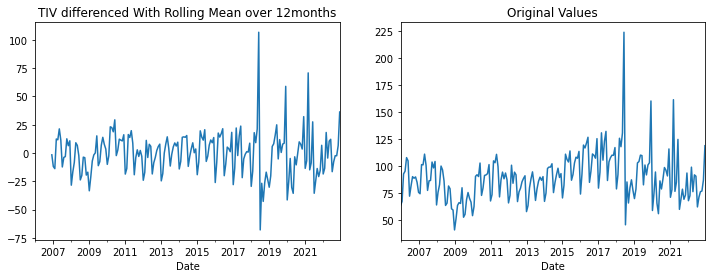

In [430]:
# Create features of the rolling mean (detrended)
w = 12
rolling_mean = df[dep_var].rolling(window = w).mean()
df_fe[dep_var + '_rolled_detrended'] = df_fe[dep_var] - rolling_mean
ax1 = plt.subplot(121)
df_fe[dep_var + '_rolled_detrended'].plot(figsize=(12,4), title=dep_var + ' differenced With Rolling Mean over ' + str(w) + 'months', ax=ax1);
ax2 = plt.subplot(122)
df_fe[dep_var].plot(figsize=(12,4), title="Original Values", ax=ax2);

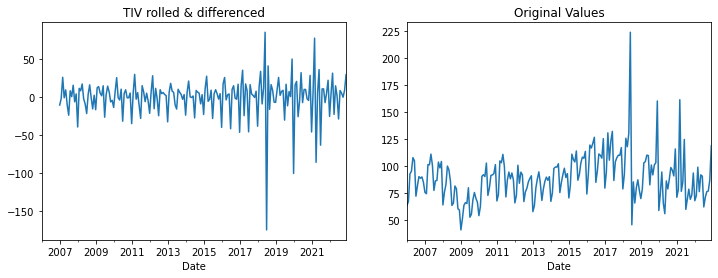

In [431]:
# Remove seasonality
# Differencing Over Time-Series with Rolling Mean taken over 12 Months
df_fe[dep_var + '_rolled_detrended_diff'] = df_fe[dep_var + '_rolled_detrended'] - df_fe[dep_var + '_rolled_detrended'].shift()
ax1 = plt.subplot(121)
df_fe[dep_var + '_rolled_detrended_diff'].plot(figsize=(8,4), title=dep_var + " rolled & differenced", ax=ax1);
ax2 = plt.subplot(122)
df_fe[dep_var].plot(figsize=(12,4), title="Original Values", ax=ax2);

In [432]:
df_fe

,Orders,CPI,UR,LTIR,TIV,Quarter,Month,Year,TIV_lag1,TIV_lag3,...,CPI_lag9,LTIR_lag9,Orders_lag9,UR_lag9,CPI_lag12,LTIR_lag12,Orders_lag12,UR_lag12,TIV_rolled_detrended,TIV_rolled_detrended_diff
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847,1,1,2006,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,303,0.608882,7.3,3.42,67.391665,1,2,2006,63.568847,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,634,1.122431,7.6,3.55,92.858327,1,3,2006,67.391665,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,1097,1.484866,8.0,3.84,95.325089,2,4,2006,92.858327,63.568847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,926,1.573034,7.4,3.89,107.940718,2,5,2006,95.325089,67.391665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900,3,8,2022,62.295680,91.959816,...,73.250224,73.250224,73.250224,73.250224,69.377673,69.377673,69.377673,69.377673,-7.700894,8.808284
2022-09-01,666,10.837620,7.1,2.08,76.413249,3,9,2022,71.260900,90.759590,...,93.680581,93.680581,93.680581,93.680581,78.727496,78.727496,78.727496,78.727496,-2.355691,5.345203
2022-10-01,711,10.853250,7.7,2.20,76.986837,4,10,2022,76.413249,62.295680,...,68.058088,68.058088,68.058088,68.058088,69.347833,69.347833,69.347833,69.347833,-2.418686,-0.062995


In [433]:
df_fe.dropna(inplace=True)

In [434]:
df_fe.columns

Index(['Orders', 'CPI', 'UR', 'LTIR', 'TIV', 'Quarter', 'Month', 'Year',
       'TIV_lag1', 'TIV_lag3', 'TIV_lag6', 'TIV_lag9', 'TIV_lag12', 'CPI_lag1',
       'LTIR_lag1', 'Orders_lag1', 'UR_lag1', 'CPI_lag3', 'LTIR_lag3',
       'Orders_lag3', 'UR_lag3', 'CPI_lag6', 'LTIR_lag6', 'Orders_lag6',
       'UR_lag6', 'CPI_lag9', 'LTIR_lag9', 'Orders_lag9', 'UR_lag9',
       'CPI_lag12', 'LTIR_lag12', 'Orders_lag12', 'UR_lag12',
       'TIV_rolled_detrended', 'TIV_rolled_detrended_diff'],
      dtype='object')

In [435]:
df_fe.shape

(192, 35)

In [436]:
columns

Index(['CPI', 'LTIR', 'Orders', 'UR'], dtype='object')

In [437]:
# Detrend and stationarize rest of features (excluding target)
columns = df.columns.difference([dep_var])
for c in columns:
    df_fe[c + '_diff'] = df_fe[c].diff()
    rolling_mean = df[c].rolling(window = w).mean()
    df_fe[c + '_rolled_detrended'] = df_fe[c] - rolling_mean
    df_fe[c + '_rolled_detrended_diff'] = df_fe[c + '_rolled_detrended'] - df_fe[c + '_rolled_detrended'].shift()

In [438]:
df_fe = df_fe.dropna()

In [439]:
df_fe.columns

Index(['Orders', 'CPI', 'UR', 'LTIR', 'TIV', 'Quarter', 'Month', 'Year',
       'TIV_lag1', 'TIV_lag3', 'TIV_lag6', 'TIV_lag9', 'TIV_lag12', 'CPI_lag1',
       'LTIR_lag1', 'Orders_lag1', 'UR_lag1', 'CPI_lag3', 'LTIR_lag3',
       'Orders_lag3', 'UR_lag3', 'CPI_lag6', 'LTIR_lag6', 'Orders_lag6',
       'UR_lag6', 'CPI_lag9', 'LTIR_lag9', 'Orders_lag9', 'UR_lag9',
       'CPI_lag12', 'LTIR_lag12', 'Orders_lag12', 'UR_lag12',
       'TIV_rolled_detrended', 'TIV_rolled_detrended_diff', 'CPI_diff',
       'CPI_rolled_detrended', 'CPI_rolled_detrended_diff', 'LTIR_diff',
       'LTIR_rolled_detrended', 'LTIR_rolled_detrended_diff', 'Orders_diff',
       'Orders_rolled_detrended', 'Orders_rolled_detrended_diff', 'UR_diff',
       'UR_rolled_detrended', 'UR_rolled_detrended_diff'],
      dtype='object')

In [440]:
df_fe.shape

(191, 47)

### Feature Selection

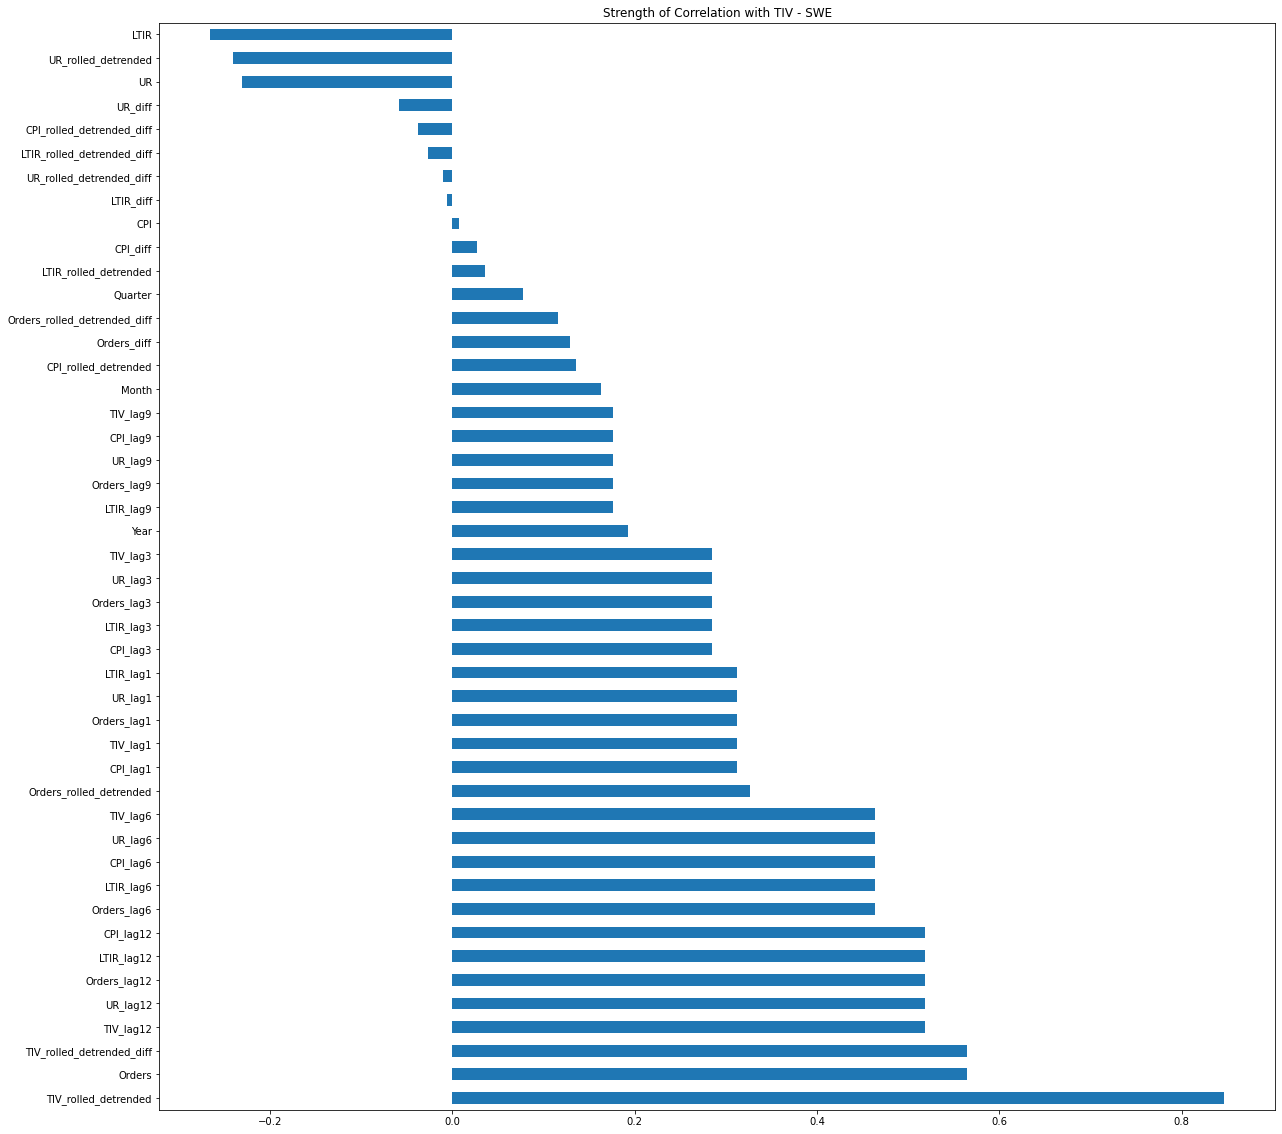

In [441]:
figure(figsize=(20, 20))

corr = df_fe.loc[:, df_fe.columns != dep_var].corrwith(df_fe[dep_var])
corr.sort_values(ascending=False).plot.barh(title = 'Strength of Correlation with ' + dep_var + ' - ' + country);

In [442]:
#Correlation with output variable using Pearson Correlation
threshold = 0.55
cor = df_fe.corr()
cor_target = abs(cor[dep_var])

#Selecting highly correlated features
relevant_features = cor_target[(cor_target > threshold)].to_frame()
relevant_features

,TIV
Orders,0.564578
TIV,1.000000
TIV_rolled_detrended,0.846754
TIV_rolled_detrended_diff,0.564335


In [443]:
# Keep only meaningful features
df_fe_fs = df_fe[relevant_features.index]

### Save file with feature selection

In [444]:
# Save data to Excel  
with pd.ExcelWriter("Datasets/Output_files/1.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_fe_fs.to_excel(writer, sheet_name=country) 